# Retrospective analysis

In [1]:
import os
import numpy as np
import seaborn as sns
from pymbar import BAR
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from glob import glob
import pickle
from simtk.openmm import unit
import bz2
from beryllium import plotting, stats
import pandas as pd
import json
import tqdm
from openmmtools.constants import kB
import networkx as nx
import random
temperature = 300.0 * unit.kelvin
kT = kB * temperature

In [2]:
retro_jsons = [f'/Users/brucemah/bin/covid-moonshot-new/synthetic-enumeration/{x}' for x in os.listdir('/Users/brucemah/bin/covid-moonshot-new/synthetic-enumeration/') if 'retro' in x or 'fastgrant' in x and 'json' in x]                        

In [191]:
from perses.analysis.fah_analysis import *

output = free_energies(retro_jsons[0], '../data/work-13420.pkl.bz2','PROJ13420','PROJ13421',cache_dir='/Users/brucemah/Desktop/temp_cache')

INFO:root:Loading FAH output from ../data/work-13420.pkl.bz2
INFO:root:22703640 switches loaded
INFO:root:Loading simulation parameters from...
INFO:root:	 /Users/brucemah/bin/covid-moonshot-new/synthetic-enumeration/2020-08-02-retrospective-aminopyridines-matt.json


In [192]:
# import json
# # from json import JSONEncoder

# class NumpyArrayEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return json.JSONEncoder.default(self, obj)
    
# with open('retrospective.json', 'w') as f:
#     json.dump(output, f, cls=NumpyArrayEncoder)

store_json(output, 'retrospective.json')

INFO:root:json file saved at retrospective.json


In [5]:
ligand_result = {0: (0.,0.,0.)}

# TODO -- this assumes that everything is star-shaped, linked to ligand 0. If it's not, the values in ligand_result and ligand_result_uncertainty won't be correct.
for d in output.values():
    
    if "complex_fes" in d and "solvent_fes" in d:
        ligand_result[d["end"]] = (np.mean(d['binding_fe'][0]),d['binding_fe'][1], d['binding_fe'][2] )
#         print(d['binding_fe'][2])

In [47]:
def plot_convergence(results, n_gens=3, title=None):
    if "complex_fes" in results and "solvent_fes" in results:
        max_gen = 0
        for i in range(n_gens):
            try:
                DDG = ((results[f"solvent_fes_GEN{i}"][0]- results[f"complex_fes_GEN{i}"][0])* kT).value_in_unit(unit.kilocalories_per_mole)
                low = ((results[f"solvent_fes_GEN{i}"][1]- results[f"complex_fes_GEN{i}"][2])* kT).value_in_unit(unit.kilocalories_per_mole)
                high = ((results[f"solvent_fes_GEN{i}"][2]- results[f"complex_fes_GEN{i}"][1])* kT).value_in_unit(unit.kilocalories_per_mole)
                plt.scatter(i, DDG, color='green')
                plt.vlines(i,low,high,color='green')
                if i > max_gen:
                    max_gen = i
            except KeyError:
                continue

        colors = {'solvent': 'blue', 'complex': 'red'}
        for phase in ['solvent', 'complex']:
            y = []
            low = []
            high = []
            for i in range(n_gens):
                try:
                    y.append((results[f"{phase}_fes_GEN{i}"][0] * kT)
                             .value_in_unit(unit.kilocalories_per_mole))
                    low.append((results[f"{phase}_fes_GEN{i}"][1] * kT)
                             .value_in_unit(unit.kilocalories_per_mole))
                    high.append((results[f"{phase}_fes_GEN{i}"][2] * kT)
                             .value_in_unit(unit.kilocalories_per_mole))
                    if i > max_gen:
                        max_gen = i
                except KeyError:
                    continue
            shift = np.mean(y)
            y = y - shift
            low = low - shift
            high = high - shift
            plt.scatter([i for i in range(0, max_gen+1)],  y,
                        color=colors[phase],label=phase)
            for i,_ in enumerate(y):
                plt.vlines(i,low[i],high[i],color=colors[phase])

        plt.xlabel('GEN')
        plt.ylabel('Relative free energy /'+r' kcal mol${^-1}$')
        plt.plot([0, max_gen],
                 [(results['binding_fe'][0]* kT).value_in_unit(unit.kilocalories_per_mole), (results['binding_fe'][0]* kT).value_in_unit(unit.kilocalories_per_mole)],
                 color='green', linestyle=":", label='free energy (all GENS)')
        plt.fill_between([0, max_gen],
                         (results['binding_fe'][1]* kT).value_in_unit(unit.kilocalories_per_mole),
                         (results['binding_fe'][2]* kT).value_in_unit(unit.kilocalories_per_mole),
                         alpha=0.2, color='green')
        plt.xticks([i for i in range(0, max_gen+1)])
        plt.legend()

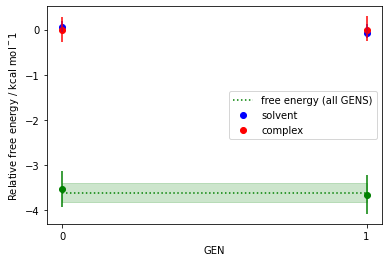

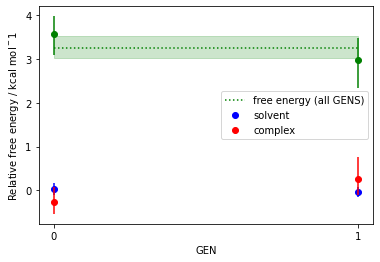

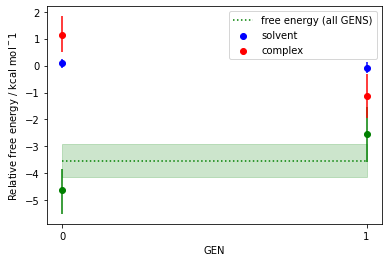

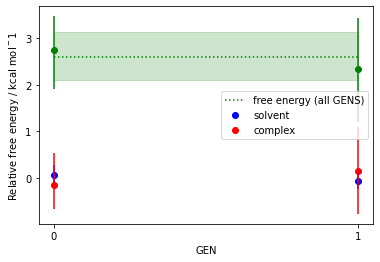

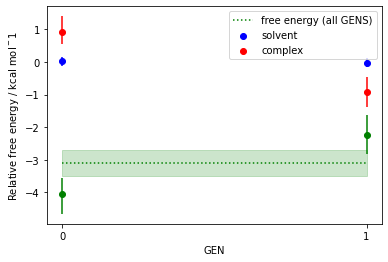

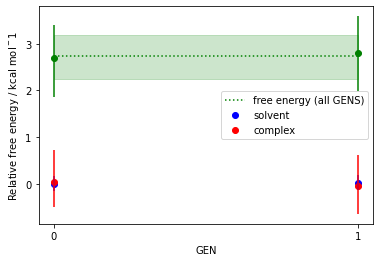

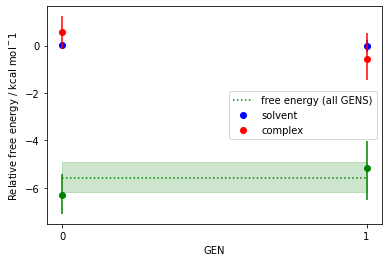

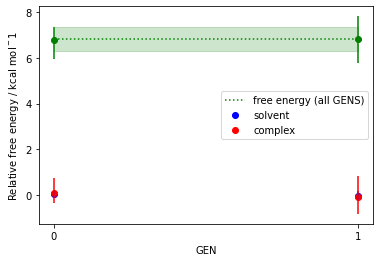

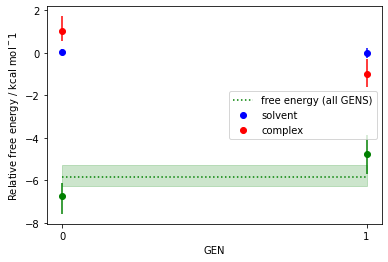

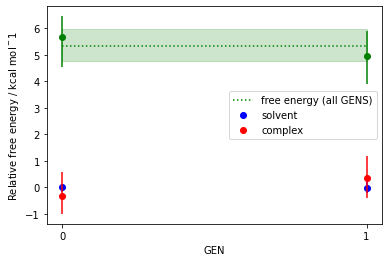

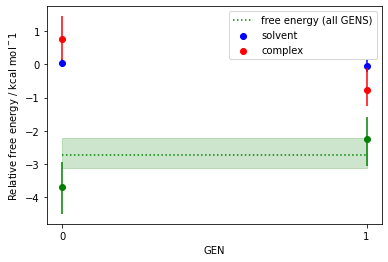

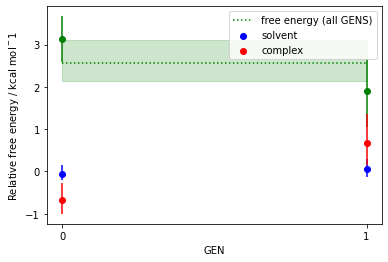

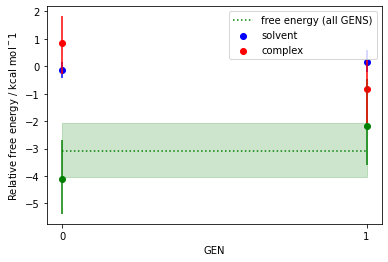

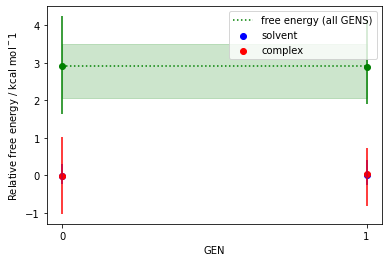

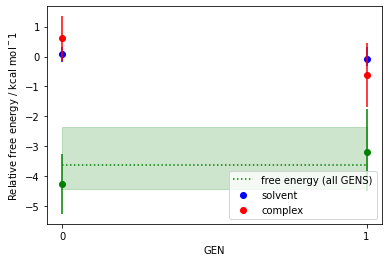

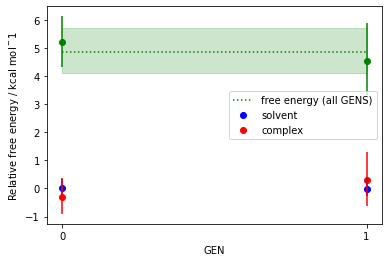

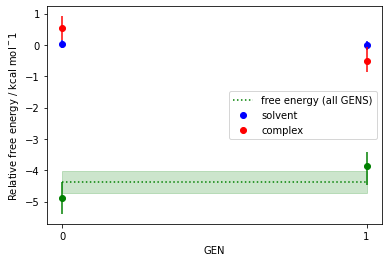

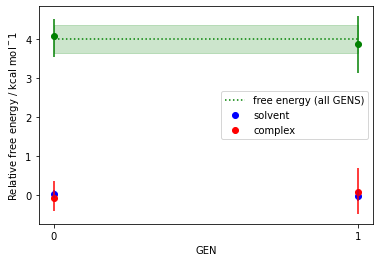

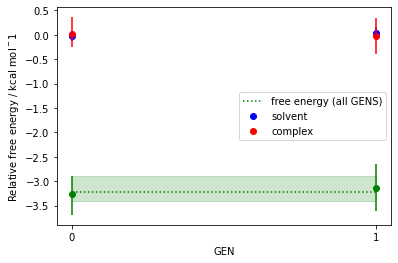

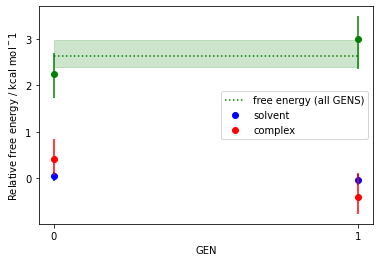

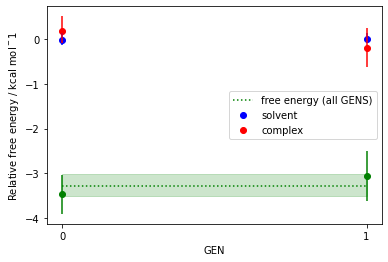

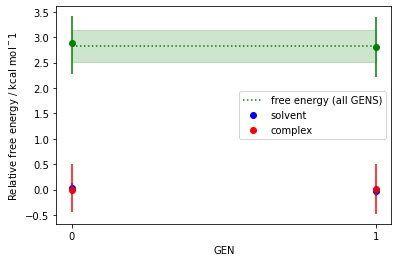

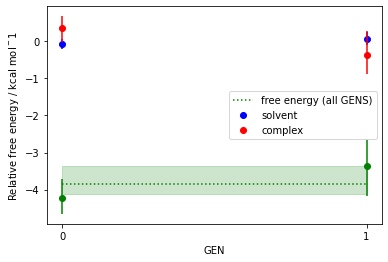

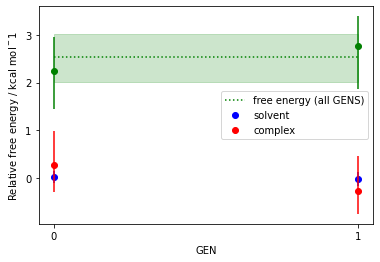

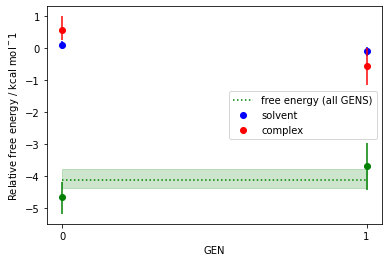

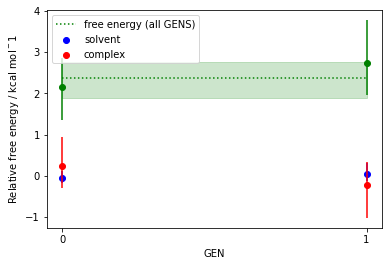

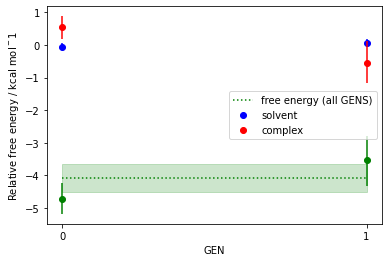

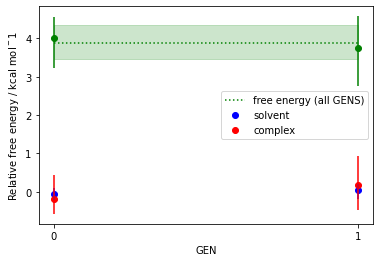

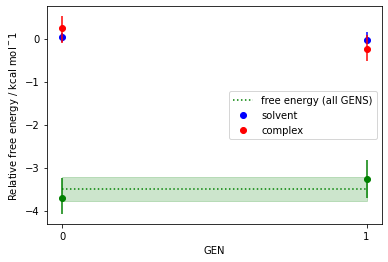

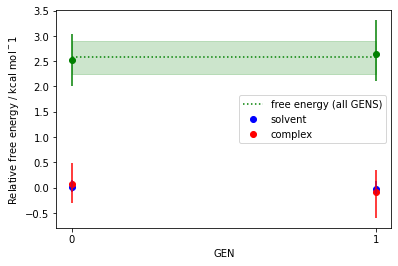

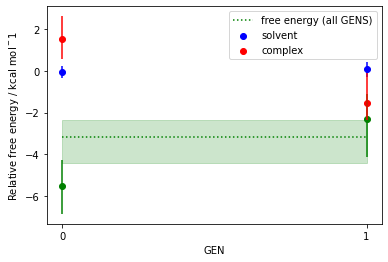

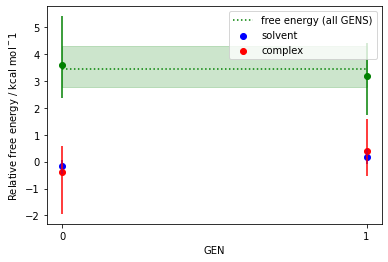

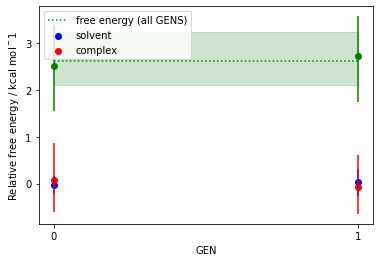

KeyboardInterrupt: 

In [48]:
for res in output.values():
    plot_convergence(res)
    plt.show()

INFO:root:Writing rel_fe_hist.pdf


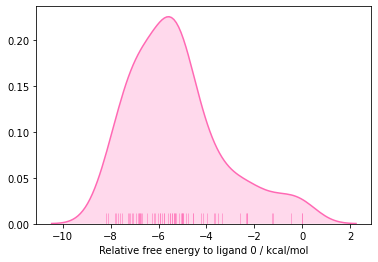

In [52]:
from perses.analysis.fah_plotting import plot_relative_distribution

# def plot_relative_distribution(relative_fes, bins=100, title="rel_fe_hist"):
#     """ Plots the distribution of relative free energies

#     Parameters
#     ----------
#     relative_fes : list
#         Relative free energies in kcal/mol
#     bins : int, default=100
#         Number of bins for histogramming


#     """
#     sns.kdeplot(
#         relative_fes, shade=True, color="hotpink")
#     sns.rugplot(
#         relative_fes,
#         color="hotpink",
#         alpha=0.5,
#         label=f"N={len(relative_fes)}",
#     )
#     plt.xlabel("Relative free energy to ligand 0 / kcal/mol")
#     _produce_plot(title)

free_energies = [x[0] for x in ligand_result.values()]

plot_relative_distribution(free_energies,bins=20)
plt.show()

In [53]:
print(output['7802'])

{'JOBID': 7802, 'directory': 'RUN7801', 'end': 1, 'end_smiles': 'c1cc(cc(c1)C#N)CC(=O)Nc2cccnc2', 'end_title': 'ANN-UNI-26382800-5', 'ff': 'openff-1.2.0', 'ligand': 'aminopyridine_compounds_for_FEP_benchmarking-conformers-x10789.sdf', 'protein': '../receptors/monomer/Mpro-x2646_0_bound-protein.pdb', 'start': 0, 'start_smiles': 'Cc1ccncc1NC(=O)Cc2cc(cc(c2)Cl)O[C@@H]3CC(=O)N3', 'start_title': 'TRY-UNI-2eddb1ff-7', 'target': 'SARS-CoV-2 Mpro', 'complex_fes_GEN0': (-26.251522356324564, -26.71486490789949, -25.78597760273778), 'complex_dfes_GEN0': 0.24623733807441026, 'complex_fes_GEN1': (-26.25259898866828, -26.692105774114196, -25.753531452750423), 'complex_dfes_GEN1': 0.23018367169786647, 'complex_fes': (-26.195977785353925, -26.492411648540276, -25.903893573659325), 'solvent_fes_GEN0': (-32.17344462230381, -32.37268585782514, -31.96476367052334), 'solvent_dfes_GEN0': 0.10215695106647057, 'solvent_fes_GEN1': (-32.40672951777944, -32.60190637471448, -32.09698874175563), 'solvent_dfes_GEN1

In [54]:
# checking to see if any

for d in output.values():
    if 'TRY-UNI-2eddb1ff-7' not in [d['start_title'], d['end_title']]:
        print(d)

In [55]:
all_molecules = [d['start_title'] for d in output.values()] + [d['end_title'] for d in output.values()]
all_molecules = set(all_molecules)

index_to_title = {i:t for i,t in enumerate(all_molecules)}
title_to_index = {t:i for i,t in enumerate(all_molecules)}

* Which is more accurate? Backwards (docked to X-ray) or forwards (Xray to docked)?
* Which is more accurate? Cys145/His45, or Cys145(-)/His45(+)?
* How well can we predict loss of affinity? Gain or maintenance of affinity?
* For the small subset with IC50 data, do we have a numerical accuracy in DeltaDeltaG we could report?

In [ ]:
import networkx as nx

# protein_files = {'../receptors/monomer/Mpro-x2646_0_bound-protein.pdb':'neutral','../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb':'charged'}

graphs = {'neutral-f':nx.DiGraph(),'neutral-r':nx.DiGraph(),'neutral-both':nx.DiGraph(),'charged-f':nx.DiGraph(),'charged-r':nx.DiGraph(),'charged-both':nx.DiGraph()}

for d in output.values():
    if 'complex_fes' in d and 'solvent_fes' in d:  
        protein = d['protein']
        DDG = d['binding_fe'][0] 
        if np.abs(DDG) > 100:
            continue
        dDDG = 1.96 * (d['binding_fe'][1] / (100)**0.5)
        if d['start_title'] == 'TRY-UNI-2eddb1ff-7':
            graph = graphs[f'{protein_files[protein]}-f']
        else:
            graph = graphs[f'{protein_files[protein]}-r']
        graph.add_edge(d['start_title'],d['end_title'],calc_DDG=DDG, calc_dDDG=dDDG, calc_DDG_low = d['binding_fe'][1],calc_DDG_high = d['binding_fe'][2], exp_DDG=0.,exp_dDDG=0.1)
        
        graph = graphs[f'{protein_files[protein]}-both']
        graph.add_edge(d['start_title'],d['end_title'],calc_DDG=DDG, calc_dDDG=dDDG,exp_DDG=0.,exp_dDDG=0.1)

In [139]:
import networkx as nx

# protein_files = {'../receptors/monomer/Mpro-x2646_0_bound-protein.pdb':'neutral','../receptors/monomer/Mpro-x2646_0_bound-protein-thiolate.pdb':'charged'}

graphs = {}

for d in output.values():
    protein = d['protein']
    ligand = d['ligand']

    if d['start_title'] == 'TRY-UNI-2eddb1ff-7':
        direction = 'forwards'
    else:
        direction = 'backwards'  
    
    # see if a graph exists for the given protein-ligand combination 
    if (protein, ligand, direction) not in graphs:
        # see if a graph exists for the given protein-ligand combination 
        graphs[(protein, ligand, direction)] = nx.DiGraph()
    if (protein, ligand, 'both') not in graphs:
        graphs[(protein, ligand, 'both')] = nx.DiGraph()
    graph = graphs[(protein, ligand, direction)]
    if 'complex_fes' in d and 'solvent_fes' in d:  

        DDG = d['binding_fe'][0] 
        dDDG = d['binding_dfe']
        if np.abs(DDG) > 100:
            continue

        graph.add_edge(d['start_title'],d['end_title'],calc_DDG=DDG, calc_dDDG=dDDG, calc_DDG_low = d['binding_fe'][1],calc_DDG_high = d['binding_fe'][2], exp_DDG=0.,exp_dDDG=0.1)
        graph = graphs[(protein, ligand, 'both')]
        graph.add_edge(d['start_title'],d['end_title'],calc_DDG=DDG, calc_dDDG=dDDG, calc_DDG_low = d['binding_fe'][1],calc_DDG_high = d['binding_fe'][2], exp_DDG=0.,exp_dDDG=0.1)
        
        

In [157]:
from beryllium import plotting, stats

to_delete = []

comb_graphs = [t for t in graphs if 'both' in t]
for t in comb_graphs:
    old_graph = graphs[t]
    graphs[(t[0],t[1],'comb')] = nx.DiGraph()
    new_graph = graphs[(t[0],t[1],'comb')]
    x = []
    y = []
    for edge in old_graph.edges(data=True):
        if edge[0] == 'TRY-UNI-2eddb1ff-7':
            if old_graph.has_edge(edge[1],edge[0]):
                x.append(edge[2]['calc_DDG'])
                y.append(-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG'])
                new_graph.add_edge(edge[0],edge[1],
                               calc_DDG=0.5*(edge[2]['calc_DDG']-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG']), 
                               calc_DDG_low=0.5*(edge[2]['calc_DDG_low']-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG_low']), # this isn't right 
                               calc_DDG_high=0.5*(edge[2]['calc_DDG_high']-old_graph.get_edge_data(edge[1],edge[0])['calc_DDG_high']), # this isn't right
                               calc_dDDG=(edge[2]['calc_dDDG']**2+old_graph.get_edge_data(edge[1],edge[0])['calc_dDDG']**2)**0.5,
                               exp_DDG=0.,exp_dDDG=0.1)
    plotting._master_plot(np.asarray(x), np.asarray(y),title=f"{t[0]}\n{t[1]}\n{t[2]}", xlabel=r'0$\rightarrow$x', ylabel=r'x$\rightarrow$0')
    to_delete.append(t)

for d in to_delete:
    del graphs[d]

In [158]:
import csv
r_inhib_20 = {}
r_inhib_50 = {}
r_ic50 = {}
f_inhib_20 = {}
f_inhib_50 = {}
f_ic50 = {}

def _ic50_to_dG(x,s_conc=375E-9,Km=40E-6):
    Ki = (x*1E-6) / (1 + (s_conc/Km))
    return 0.59*np.log(Ki)

def _inhibition_to_kd(percentage, concentration):
    fraction = percentage / 100.
    # using equation 7 from https://www.molbiolcell.org/doi/10.1091/mbc.e10-08-0683#F1
    kd = concentration*((1 - fraction)/fraction)
    return _ic50_to_dG(kd)

def best_guess_expt(m, threshold=10):
    # use IC50s if possible
    experimentals = [m[x] for x in m.keys() if 'IC50' in x]
    experimentals = [_ic50_to_dG(x) for x in experimentals]
    if len(experimentals) > 0:
        return (np.mean(experimentals), np.std(experimentals))  
    
    # if no IC50, try 20uM if > threshold
    experimentals = [m[x] for x in m.keys() if 'inhib20uM' in x and m[x] > threshold]
    experimentals = [_inhibition_to_kd(x,20) for x in experimentals]
    if len(experimentals) > 0:
        return (np.mean(experimentals), np.std(experimentals))   
    
    # else try 50uM
    experimentals = [m[x] for x in m.keys() if 'inhib50uM' in x if m[x] > 0]
    experimentals = [_inhibition_to_kd(x,50) for x in experimentals]
    if len(experimentals) > 0:
        return (np.mean(experimentals), np.std(experimentals))  
    else:
        return (None, None)
    


experimental = {}
with open('activity-data-2020-07-29.csv','r') as f:
    x = csv.reader(f)
    for i, row in enumerate(x):
        if i == 0:
            continue

        name = row[1]
        contents = ['r_inhib20uM','r_inhib50uM','r_IC50','f_inhib20uM','f_inhib50uM','f_IC50']
        experimental[name] = {}
        for i, c in enumerate(contents, 3):
            if row[i] != '':
                if float(row[i]) < 0.:
                    row[i] = 0.
                if float(row[i]) > 100.:
                    row[i] = 100.
                experimental[name][c] = float(row[i])
        dg , ddg = best_guess_expt(experimental[name])
        if dg is not None:
            experimental[name]['DG'] = dg
            experimental[name]['dDG'] = ddg
                
            

for g in graphs.values():
    nx.set_node_attributes(g, experimental)

/Users/brucemah/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

divide by zero encountered in log

/Users/brucemah/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:193: RuntimeWarning:

invalid value encountered in subtract



/Users/brucemah/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:

divide by zero encountered in log



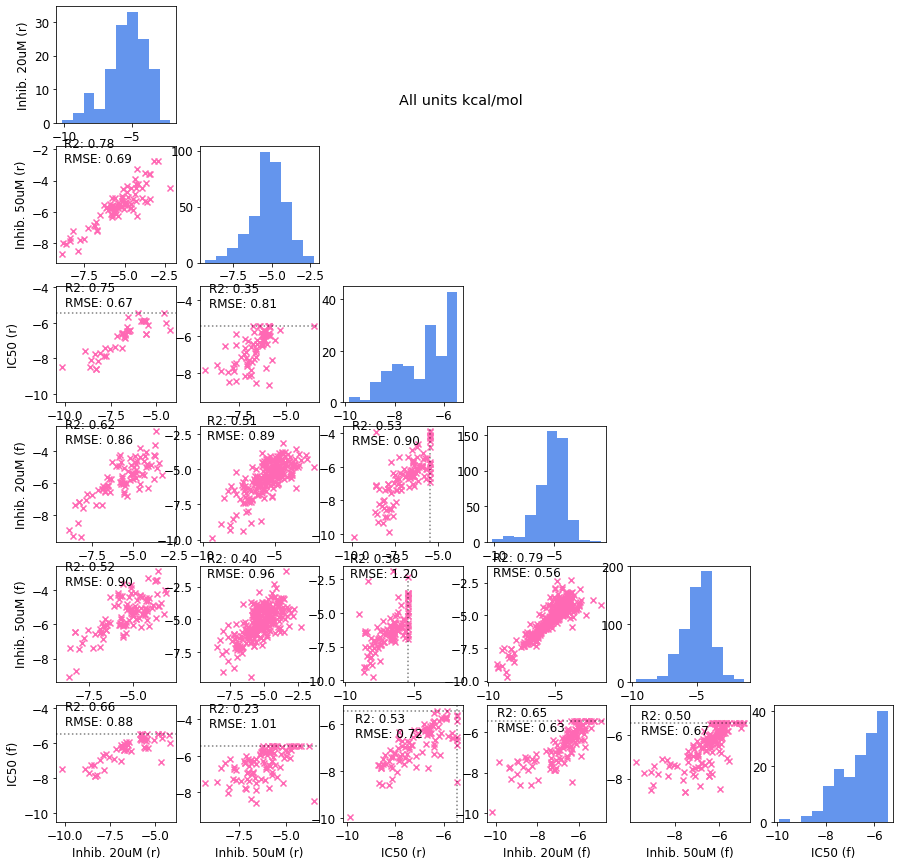

In [159]:
fig, axes = plt.subplots(ncols=6,nrows=6,figsize=(15,15))
import itertools
contents = ['r_inhib20uM','r_inhib50uM','r_IC50','f_inhib20uM','f_inhib50uM','f_IC50']
hist = {c:[] for c in contents}
scatters = {(j,i):[[],[]] for i,j in itertools.combinations(range(0,6),2)}

for exp in experimental.values():
    res = []
    for val in contents:
        if val in exp.keys():
            if 'IC50' in val:
                res.append(_ic50_to_dG(exp[val]))
            elif 'inhib20' in val and exp[val] > 0.:
                res.append(_inhibition_to_kd(exp[val],20))
            elif 'inhib50' in val and exp[val] > 0.:
                res.append(_inhibition_to_kd(exp[val],50))
            else:
                res.append(None)
        else:
            res.append(None)
            
    for i,c in enumerate(contents):
        if res[i] is not None:
            hist[c].append(res[i])

    for i,j in itertools.combinations(range(0,6),2):
        if res[i] is not None and res[j] is not None:
            scatters[(j,i)][0].append(res[i])
            scatters[(j,i)][1].append(res[j])
            
    contents_formal = ['Inhib. 20uM (r)','Inhib. 50uM (r)','IC50 (r)','Inhib. 20uM (f)','Inhib. 50uM (f)','IC50 (f)']
    for i,label in enumerate(contents_formal):
        axes[5][i].set_xlabel(f'{label}')
        axes[i][0].set_ylabel(f'{label}')
        
for i,c in enumerate(contents):
    axes[i][i].hist([x for x in hist[c] if x is not None and not np.isinf(x)],color='cornflowerblue')
    
limits = [_inhibition_to_kd(100.,20),_inhibition_to_kd(100.,50),_ic50_to_dG(99.),_inhibition_to_kd(100.,20),_inhibition_to_kd(100.,50),_ic50_to_dG(99.)]   

for i,j in itertools.combinations(range(0,6),2):
    xs = []
    ys = []
    for x,y in zip(scatters[(j,i)][0], scatters[(j,i)][1]):
        if x is not None and y is not None and not np.isinf(x) and not np.isinf(y):
            xs.append(x)
            ys.append(y)

    axes[j][i].scatter(xs,ys,color='hotpink',marker='x')
    string = ''
    for stat in ['R2','RMSE']:
        s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic=stat)
        string += f"{stat}: {s['mle']:.2f}\n"  
    
    
    y_low, y_high = axes[j][i].get_ylim()
    x_low, x_high = axes[j][i].get_xlim()
    low = min(x_low,y_low)
    high = max(x_high,y_high)
    axes[j][i].text(low+0.5, high-2.,string)    

    axes[j][i].set_xlim(low,high)
    axes[j][i].set_ylim(low,high)
    axes[i][j].axis('off')
    
    # now plot the limits
    axes[j][i].hlines(limits[j],low,high,'k',linestyle=':',alpha=0.5)
    axes[j][i].vlines(limits[i],low,high,'k',linestyle=':',alpha=0.5)
plt.suptitle('All units kcal/mol',y=0.8)

plt.show()

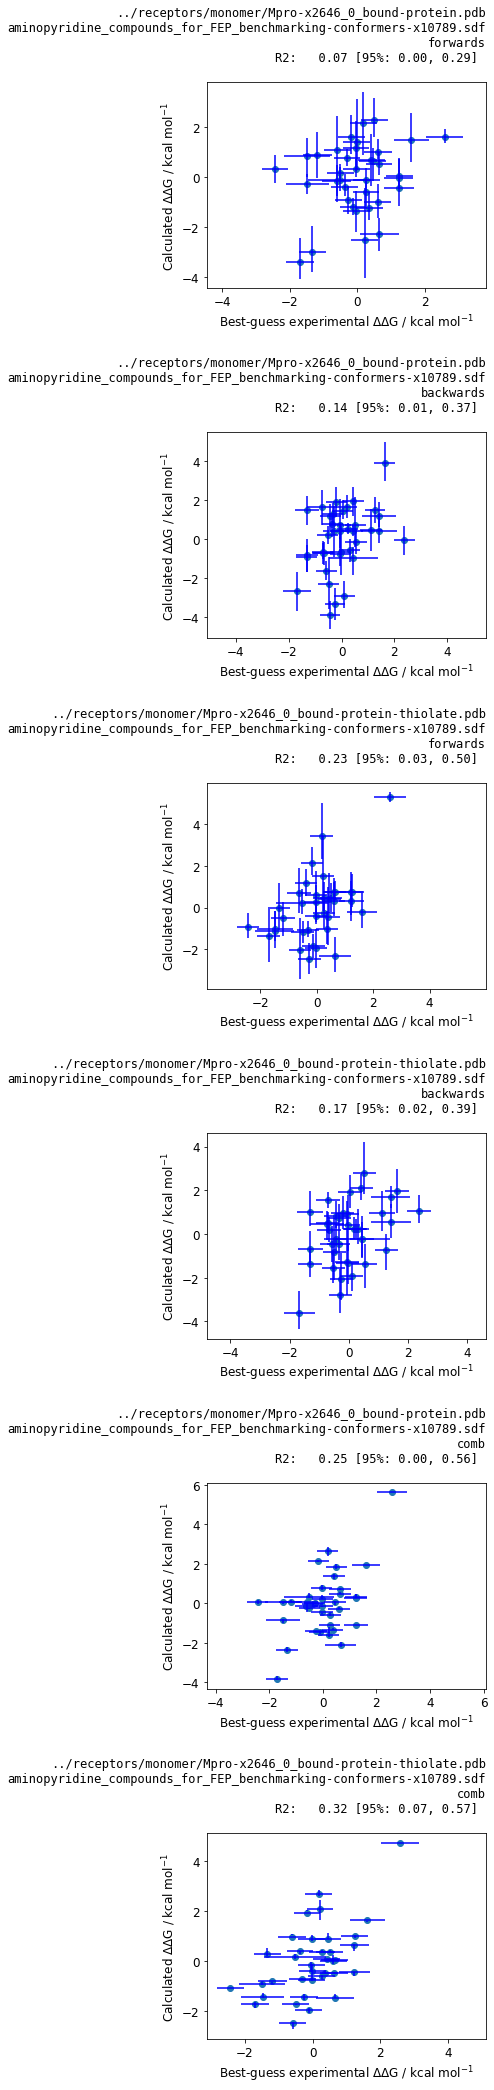

In [160]:
fig, axes = plt.subplots(ncols=1,nrows=len(graphs),figsize=(5, 6*len(graphs)))


for i, t in enumerate(graphs.keys()):
    g = graphs[t]
    xs = []
    x_err = []
    y_low = []
    y_high = []
    ys = []
    for edge in g.edges(data=True):
        try:
            
#             print(nx.get_node_attributes(g,'DG'))
            expt = nx.get_node_attributes(g,'DG')[edge[0]] - nx.get_node_attributes(g,'DG')[edge[1]]
            dexpt = (nx.get_node_attributes(g,'dDG')[edge[0]]**2 + nx.get_node_attributes(g,'dDG')[edge[1]]**2)**0.5
            ys.append(edge[2]['calc_DDG'])
            y_low.append(edge[2]['calc_DDG_low'])
            y_high.append(edge[2]['calc_DDG_high'])
            xs.append(expt)
            x_err.append(dexpt)
        except:
            continue
    xs = xs - np.mean(xs)
    shift = np.mean(ys)
    ys = ys - shift
    y_low = y_low - shift
    y_high = y_high - shift
    axes[i].scatter(xs,ys)
    for x,j,k in zip(xs,y_low,y_high):
        axes[i].vlines(x, j, k, color='blue')
    axes[i].errorbar(xs,ys,xerr=x_err,ls='none',color='blue')
    y_low, y_high = axes[i].get_ylim()
    x_low, x_high = axes[i].get_xlim()
    low = min(x_low,y_low)
    high = max(x_high,y_high)
    axes[i].set_xlim(low,high)
    axes[i].set_ylim(low,high)

    statistics_string = f'{t[0]}\n{t[1]}\n{t[2]}\n'
    for statistic in ['R2']:
        s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic=statistic)
        string = f"{statistic}:   {s['mle']:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
        statistics_string += string
    axes[i].set_title(statistics_string, fontsize=12, loc='right', horizontalalignment='right', family='monospace')

    axes[i].set_ylabel(f'Calculated ΔΔG '+r'/ kcal mol$^{-1}$')
    axes[i].set_xlabel(f'Best-guess experimental ΔΔG '+r'/ kcal mol$^{-1}$')

plt.subplots_adjust(hspace = 0.7,wspace = 0.5) 
plt.show()


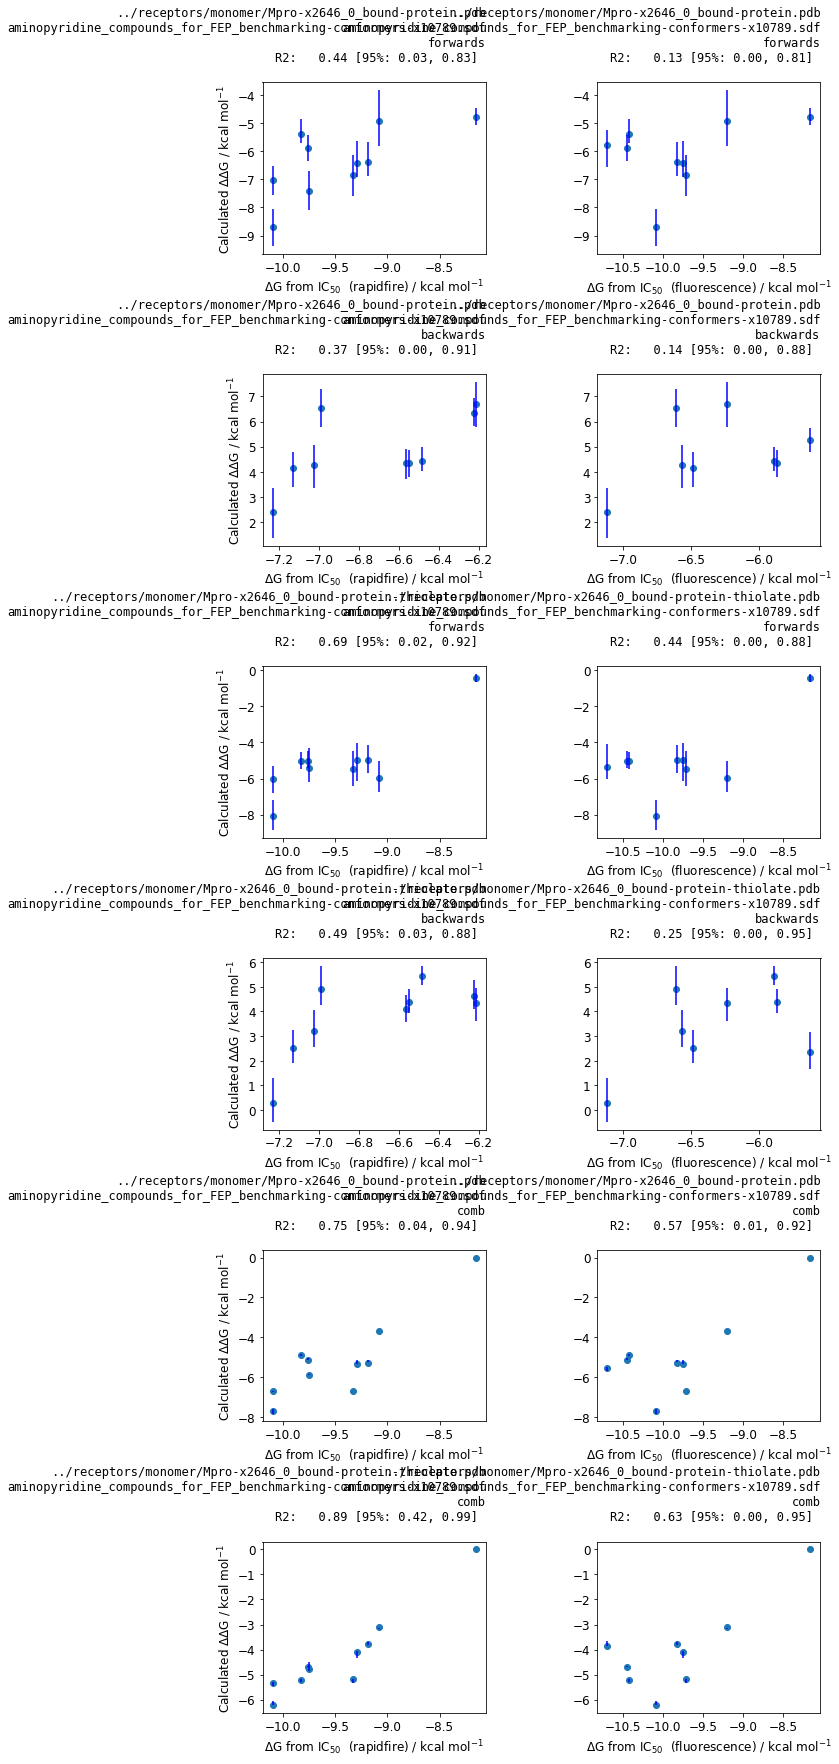

In [161]:
fig, axes = plt.subplots(ncols=2,nrows=len(graphs),figsize=(10, 5*len(graphs)))


for i, t in enumerate(graphs.keys()):
    g = graphs[t]

    for j, assay in enumerate(['f','r']):
        xs = []
        y_low = []
        y_high = []
        ys = []
        for edge in g.edges(data=True):
            try:
                # TODO if either of these are 99, we want to color the associated datapoint different
                expt = nx.get_node_attributes(g,f'{assay}_IC50')[edge[0]] / nx.get_node_attributes(g,f'{assay}_IC50')[edge[1]]
                ys.append(edge[2]['calc_DDG'])
                y_low.append(edge[2]['calc_DDG_low'])
                y_high.append(edge[2]['calc_DDG_high'])
                xs.append(_ic50_to_dG(expt))
            except:
                continue

        axes[i][j].scatter(xs,ys)
        for x,low,high in zip(xs,y_low,y_high):
            axes[i][j].vlines(x, low, high, color='blue')  
        
        statistics_string = f'{t[0]}\n{t[1]}\n{t[2]}\n'
        for statistic in ['R2']:
            s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic=statistic)
            string = f"{statistic}:   {s['mle']:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
            statistics_string += string
        axes[i][j].set_title(statistics_string, fontsize=12, loc='right', horizontalalignment='right', family='monospace')

    axes[i][0].set_ylabel(f'Calculated ΔΔG '+r'/ kcal mol$^{-1}$')
    axes[i][0].set_xlabel(r'ΔG from IC$_{50}$  (rapidfire) '+r'/ kcal mol$^{-1}$')
    axes[i][1].set_xlabel(r'ΔG from IC$_{50}$  (fluorescence) '+r'/ kcal mol$^{-1}$')
plt.subplots_adjust(hspace = 0.7,wspace = 0.5) 
plt.show()


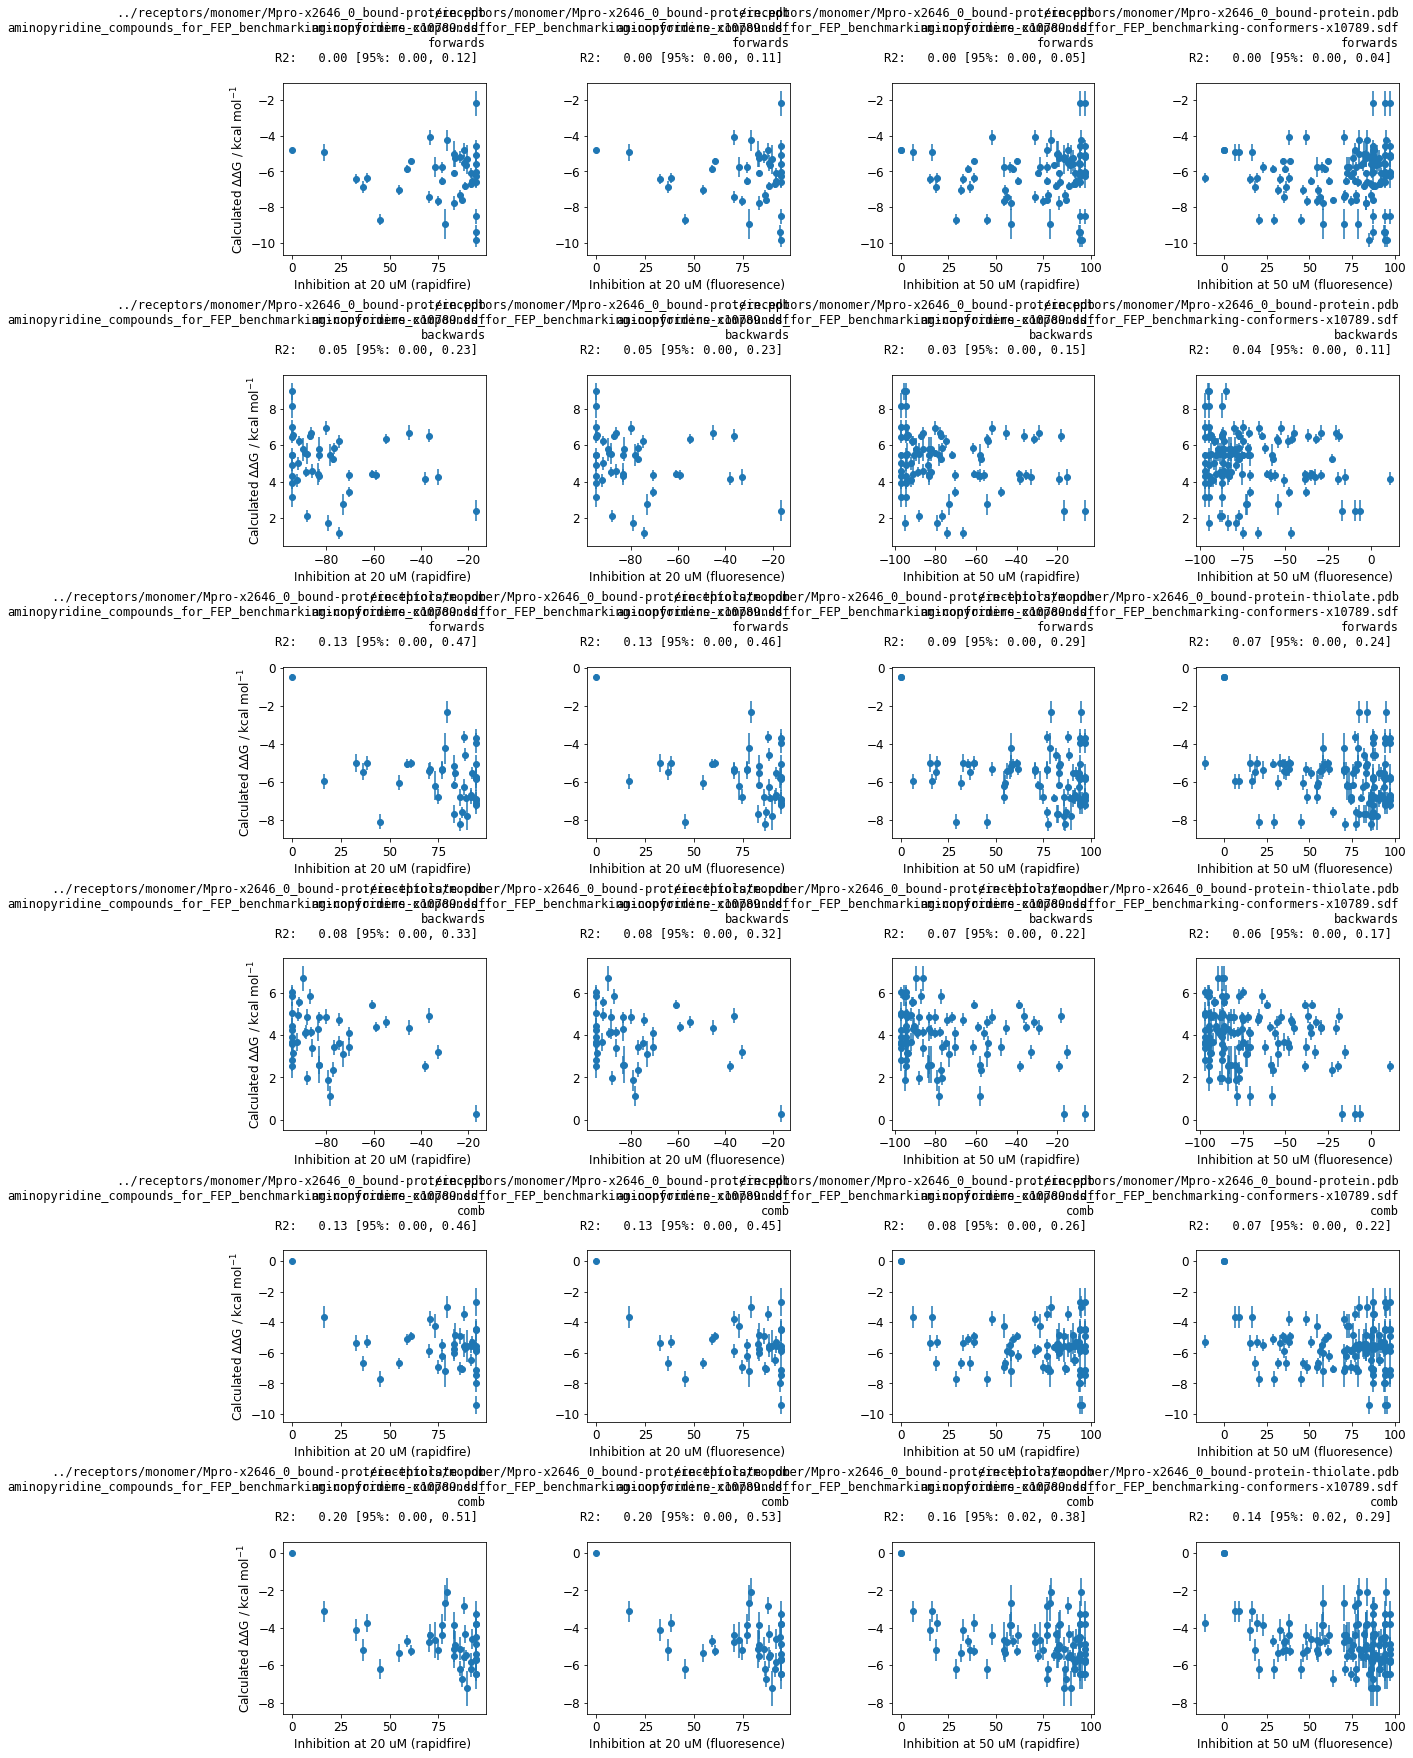

In [162]:
fig, axes = plt.subplots(ncols=4,nrows=len(graphs),figsize=(20, 5*len(graphs)))

for i, t in enumerate(graphs.keys()):
    g = graphs[t]
    xs = []
    y_err = []
    ys = []
    for j, assay in enumerate(['f_inhib20uM','r_inhib20uM','f_inhib50uM','r_inhib50uM']):
        for edge in g.edges(data=True):
            try:
                expt = nx.get_node_attributes(g,assay)[edge[0]] - nx.get_node_attributes(g,assay)[edge[1]]
                ys.append(edge[2]['calc_DDG'])
                y_err.append(edge[2]['calc_dDDG'])
                xs.append(expt)
            except:
                continue
        axes[i][j].scatter(xs,ys)
        axes[i][j].errorbar(xs,ys,yerr=y_err,ls='none')
        
        statistics_string = f'{t[0]}\n{t[1]}\n{t[2]}\n'
        for statistic in ['R2']:
            s = stats.bootstrap_statistic(np.asarray(xs),np.asarray(ys), statistic=statistic)
            string = f"{statistic}:   {s['mle']:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
            statistics_string += string
        axes[i][j].set_title(statistics_string, fontsize=12, loc='right', horizontalalignment='right', family='monospace')

    axes[i][0].set_ylabel(f'Calculated ΔΔG '+r'/ kcal mol$^{-1}$')
    axes[i][0].set_xlabel(r'Inhibition at 20 uM (rapidfire) ')
    axes[i][1].set_xlabel(r'Inhibition at 20 uM (fluoresence) ')
    axes[i][2].set_xlabel(r'Inhibition at 50 uM (rapidfire) ')
    axes[i][3].set_xlabel(r'Inhibition at 50 uM (fluoresence) ')
plt.subplots_adjust(hspace = 0.7,wspace = 0.5) 
plt.show()


In [96]:
# # enumerated stereochemistry NEED TO COMBINE ESTIMATE FROM DIFFERENT STEREOCHEMISTRIES
# for title in title_to_index.keys():
#     print(title)

In [97]:
# def _inhibition_to_kd(percentage, concentration):
#     fraction = percentage / 100.
#     # using equation 7 from https://www.molbiolcell.org/doi/10.1091/mbc.e10-08-0683#F1
#     kd = concentration*((1 - fraction)/fraction)
#     return kd

# ### combining all
# for ligand in index_to_title.keys():
#     inhib = r_inhib_20[index_to_title[ligand]]
#     if inhib is not None and inhib > 0.:
#         kd_a = _inhibition_to_kd(inhib,20.)
#     else:
#         kd_a = None
#     inhib = r_inhib_50[index_to_title[ligand]]
#     if inhib is not None and inhib > 0.:
#         kd_b = _inhibition_to_kd(inhib,50.)
#     else:
#         kd_b = None
#     print(kd_a, kd_b, r_ic50[index_to_title[ligand]])

In [163]:
fig1_left = {'L1':'ADA-UCB-6c2cb422-1',
'L2':'TRY-UNI-714a760b-6',
'L3':'EDG-MED-0da5ad92-2',
'L4':'JAN-GHE-5a013bed-2',
'L5':'JAN-GHE-5a013bed-3',
'L6':'JAN-GHE-5a013bed-1'}


fig1_right = {
'R1':'TRY-UNI-714a760b-6',
'R2':'JAN-GHE-83b26c96-12',
'R3':'TRY-UNI-714a760b-20',
'R4':'ALP-POS-95b75b4d-2',
'R5':'EDJ-MED-e58735b6-2'}


figure_1 = {**fig1_left, **fig1_right}
reverse = {j:i for i,j in figure_1.items()}

In [184]:
def _master_plot(x, y, title='',
                 xerr=None, yerr=None,
                 method_name='', target_name='', quantity=rf'$\Delta \Delta$ G',
                 xlabel=f'Experimental', ylabel=f'Calculated', units=r'$\mathrm{kcal\,mol^{-1}}$',
                 guidelines=True, origins=True, color=None,
                 statistics=['RMSE',  'MUE'], filename=None, centralizing=True,
                 shift=0.,figsize=3.25,ax=None):
    """ Handles the aesthetics of the plots in one place.

    Parameters
    ----------
    x : list
        Values to plot on the x axis
    y : list
        Values to plot on the y axis
    title : string, default = ''
        Title for the plot
    xerr : list , default = None
        Error bars for x values
    yerr : list , default = None
        Error bars for y values
    method_name : string, optional
        name of method associated with results, e.g. 'perses'
    target_name : string, optional
        name of system for results, e.g. 'Thrombin'
    quantity : str, default = '$\Delta \Delta$ G'
        metric that is being plotted
    xlabel : str, default = 'Experimental'
        label for xaxis
    ylabel : str, default = 'Calculated'
        label for yaxis
    units : str, default = r'$\mathrm{kcal\,mol^{-1}}$'
        string value of units to label axis
    guidelines : bool, default = True
        toggles plotting of grey 0.5 and 1 kcal/mol error zone
    origins : bool, default = True
        toggles plotting of x and y axis
    color : str, default = None
        if None, will be coloured according to distance from unity
    statistics : list(str), default = ['RMSE',  'MUE']
        list of statistics to calculate and report on the plot
    filename : str, default = None
        filename for plot
    centralizing : bool, default = True
        offset the free energies
    shift : float, default = 0.
        shift both the x and y axis by a constant
    figsize : float, default = 3.25
        size of figure for matplotlib

    Returns
    -------

    """
    show = False
    if ax is None:
        fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(figsize,figsize))
        show = True
        
    nsamples = len(x)

    # aesthetics
#     ax.rcParams['xtick.labelsize'] = 12
#     ax.rcParams['ytick.labelsize'] = 12
#     ax.rcParams['font.size'] = 12

    ax.set_xlabel(f'{xlabel} {quantity} / '+units)
    ax.set_ylabel(f'{ylabel} {quantity} / '+units)

    ax_min = min(min(x), min(y)) - 1
    ax_max = max(max(x), max(y)) + 1
    scale = [ax_min, ax_max]

    ax.set_xlim(scale)
    ax.set_ylim(scale)

    scale_buffer = [ax_min-10, ax_max+10]
    # plots x-axis and y-axis
    if origins:
        ax.plot([0, 0], scale_buffer, 'gray')
        ax.plot(scale_buffer, [0, 0], 'gray')

    # plots x=y line
    ax.plot(scale_buffer, scale_buffer, 'k:')
    if guidelines:
        small_dist = 0.5
        # plots grey region around x=y line
        ax.fill_between(scale_buffer, [ax_min-10. - small_dist, ax_max+10. - small_dist],
                         [ax_min-10. + small_dist, ax_max+10. + small_dist],
                         color='grey', alpha=0.2)
        ax.fill_between(scale_buffer, [ax_min-10. - small_dist * 2, ax_max+10. - small_dist * 2],
                         [ax_min-10. + small_dist * 2, ax_max+10. + small_dist * 2],
                         color='grey', alpha=0.2)
    # actual plotting
    cm = plt.get_cmap('coolwarm')

    if color is None:
        color = np.abs(x-y)
        # 2.372 kcal / mol = 4 RT
        color = cm(color / 2.372)
    ax.errorbar(x, y, xerr=xerr, yerr=yerr, color='gray', linewidth=0., elinewidth=2., zorder=1)
    ax.scatter(x, y, color=color, s=10, marker='o', zorder=2)

    # stats and title
    statistics_string = ''
    for statistic in statistics:
        s = stats.bootstrap_statistic(x, y, xerr, yerr, statistic=statistic)
        string = f"{statistic}:   {s['mle']:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
        statistics_string += string

    long_title = f'{title} \n {target_name} (N = {nsamples}) \n {statistics_string}'

    ax.set_title(long_title, fontsize=12, loc='right', horizontalalignment='right', family='monospace')
# 
    if show:
        plt.show()


def plot_DDGs(x, y, xerr, yerr, method_name='', target_name='', title='', ax=None, centralizing=True,
              map_positive=False, filename=None, symmetrise=False, plotly=False, **kwargs):
    """ Function to plot relative free energies

    Parameters
    ----------
    graph : nx.DiGraph
        graph object with relative free energy edges
    method_name : string, optional
        name of method associated with results, e.g. 'perses'
    target_name : string, optional
        name of system for results, e.g. 'Thrombin'
    title : string, default = ''
        Title for the plot
    map_positive : bool, default=False
        whether to map all DDGs to the positive x values.
        this is an aesthetic choice
    filename : str, default = None
        filename for plot
    symmetrise : bool, default = False
        whether to plot each datapoint twice, both
        positive and negative

    Returns
    -------

    """

    assert int(symmetrise) + int(map_positive) != 2, 'Symmetrise and map_positive cannot both be True in the same plot'

    if symmetrise:
        x_data = np.append(x, [-i for i in x])
        y_data = np.append(y, [-i for i in y])
    
    elif map_positive:
        x_data = []
        y_data = []
        for i, j in zip(x, y):
            if i < 0:
                x_data.append(-i)
                y_data.append(-j)
            else:
                x_data.append(i)
                y_data.append(j)
        x_data = np.asarray(x_data)
        y_data = np.asarray(y_data)
    else:
        x_data = np.asarray(x)
        y_data = np.asarray(y)

    if symmetrise:
        xerr = np.append(xerr, xerr)
        yerr = np.append(yerr, yerr)
    xerr = [0. for _ in x]
    yerr = [0. for _ in y]

    if centralizing:
        x_data = x_data - np.mean(x_data)
        y_data = y_data - np.mean(y_data)
    
    if plotly:
        plotlying._master_plot(x_data, y_data,
                 xerr=xerr, yerr=yerr, filename=filename, plot_type='ΔΔG',
                 title=title, method_name=method_name, target_name=target_name, **kwargs)
    else:
        _master_plot(x_data, y_data,
                 xerr=xerr, yerr=yerr, filename=filename,
                 title=title, method_name=method_name, target_name=target_name, ax=ax, **kwargs)

    return

def plot_DGs(x_data,y_data,xerr,yerr, method_name='', target_name='', title='', filename=None, plotly=False, centralizing=True, shift=0., **kwargs):
    """Function to plot absolute free energies.

    Parameters
    ----------
    graph : nx.DiGraph
        graph object with relative free energy edges
    method_name : string, optional
        name of method associated with results, e.g. 'perses'
    target_name : string, optional
        name of system for results, e.g. 'Thrombin'
    title : string, default = ''
        Title for the plot
    filename : str, default = None
        filename for plot

    Returns
    -------

    """


    # centralising
    # this should be replaced by providing one experimental result
    if centralizing == True:
        shift = + np.mean(x_data) - np.mean(y_data)
        y_data = y_data + shift
    
    if plotly:
        plotlying._master_plot(x_data, y_data,
                 xerr=xerr, yerr=yerr,
                 origins=False, statistics=['RMSE','MUE','R2','rho'],plot_type='ΔG',
                 title=title, method_name=method_name, target_name=target_name, filename=filename, **kwargs)
    else:
        _master_plot(x_data, y_data,
                                   xerr=xerr, yerr=yerr,
                                   origins=False, statistics=['RMSE', 'MUE', 'R2', 'rho'], quantity=rf'$\Delta$ G',
                                   title=title, method_name=method_name, target_name=target_name, filename=filename, **kwargs)

    return

In [185]:
ic50_0 = g.nodes.data()['TRY-UNI-2eddb1ff-7']['f_IC50']
title = 'TRY-UNI-2eddb1ff-7'
non_binding = 99
plots = {}


differences = []
for i,(t, g) in enumerate(graphs.items()):
    plots[i] = {'x':[],'y':[],'xerr':[],'yerr':[],'x-out':[],'y-out':[],'yerr-out':[]}
    for node in g.nodes(data=True):
        try:
            differences.append(_ic50_to_dG(node[1]['f_IC50']) - _ic50_to_dG(node[1]['r_IC50']))
        except:
            continue

expt_CI = 1.96*np.std(differences)

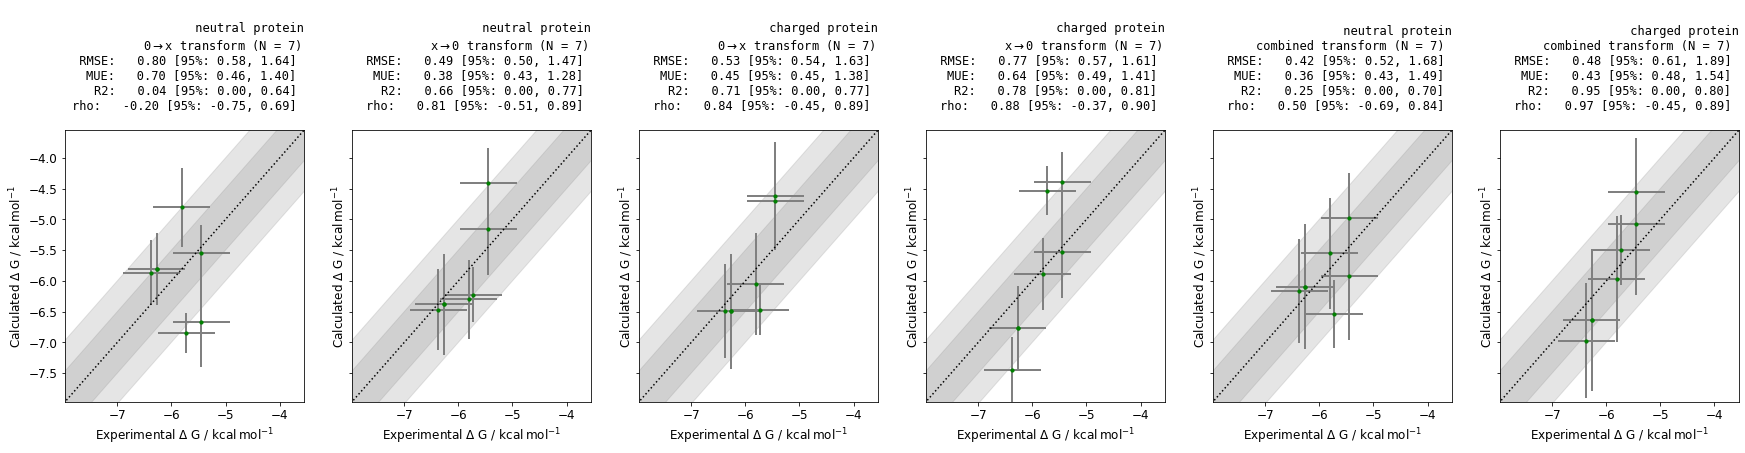

In [186]:
ic50_0 = g.nodes.data()['TRY-UNI-2eddb1ff-7']['f_IC50']
non_binding = 99
plots = {}
for i,(t, g) in enumerate(graphs.items()):
    plots[i] = {'x':[],'y':[],'yerr':[],'x-out':[],'y-out':[],'yerr-out':[]}
    for edge in g.edges(data=True):
        for title in figure_1.values(): 
            if edge[1] == title:
                try:
                    x = _ic50_to_dG(g.nodes.data()[title]['f_IC50'])
                except:
                    x = _ic50_to_dG(non_binding)
                y = edge[2]['calc_DDG']
                yerr = edge[2]['calc_dDDG']
                plots[i]['x'].append(x)
                plots[i]['y'].append(_ic50_to_dG(ic50_0) - edge[2]['calc_DDG'])
                plots[i]['yerr'].append(1.96*yerr)
            if edge[0] == title:
                try:
                    x = _ic50_to_dG(g.nodes.data()[title]['f_IC50'])
                except:
                    x = _ic50_to_dG(non_binding)
                y = edge[2]['calc_DDG']
                yerr = edge[2]['calc_dDDG']
                plots[i]['x'].append(x)
                plots[i]['y'].append(-_ic50_to_dG(ic50_0) + edge[2]['calc_DDG'])
                plots[i]['yerr'].append(1.96*yerr)

                
titles = [f'neutral protein\n'+r'0$\rightarrow$x transform',
         f'neutral protein\n'+r'x$\rightarrow$0 transform',
         f'charged protein\n'+r'0$\rightarrow$x transform',
         f'charged protein\n'+r'x$\rightarrow$0 transform',
         f'neutral protein\n'+r'combined transform',
         f'charged protein\n'+r'combined transform']
fig, axes = plt.subplots(ncols=6,nrows=1,figsize=(30,5),sharex=True,sharey=True)
for i,t in enumerate(graphs):
    xs = np.asarray(plots[i]['x'])
    ys = np.asarray(plots[i]['y'])
    yerr = np.asarray(plots[i]['yerr'])
    plot_DGs(xs,ys,[expt_CI for _ in xs],yerr, centralizing=True,ax=axes[i],color='green',target_name=titles[i])

plt.show()